# start

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import os
import numpy as np

import copy
from transformers import BertForSequenceClassification, BertTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
from collections import defaultdict

folder = "test_results"
os.makedirs(folder, exist_ok=True)

# track neff with beta

In [5]:
def mask_per_column_rate(module:nn.Module, beta=1.0) -> torch.Tensor:
    x = module.weight.data
    output_size, input_size = x.shape
    params_num = output_size
    x_norm = torch.abs(x) / torch.sum(torch.abs(x), dim=0, keepdim=True)
    neff = 1/torch.sum((x_norm ** 2), dim=0, keepdim=True).squeeze(0)
    r_neff = torch.floor(beta * neff)
    r_neff = r_neff.clamp(min=max(int(0.2*params_num), 1), max=int(0.8*params_num))

    #print(f'neff is {neff} and the corresponding r_neff is {r_neff}')
    _, indices = torch.sort(x_norm, dim=0, descending=True)
    range_tensor = torch.arange(output_size, device=x.device).unsqueeze(0).expand(input_size, -1).T
    sorted_mask = range_tensor < r_neff

    mask = torch.zeros_like(x, dtype=torch.bool)
    mask.scatter_(0, indices, sorted_mask)
    return mask

def model_per_column_rate(model, renormalize=False, beta=1.0):
    model = copy.deepcopy(model)
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            mask = mask_per_column_rate(module, beta).to(module.weight.device)
            with torch.no_grad():
                pre = module.weight.abs().sum(dim=0, keepdim=True)
                module.weight *= mask
                if renormalize:
                    post = module.weight.abs().sum(dim=0, keepdim=True)
                    module.weight.mul_(pre / post)
    return model

def mask_per_row_rate(module:nn.Module, beta=1.0) -> torch.Tensor:
    x = module.weight.data
    output_size, input_size = x.shape
    params_num = input_size
    x_norm = torch.abs(x) / torch.sum(torch.abs(x), dim=1, keepdim=True)
    neff = 1/torch.sum((x_norm ** 2), dim=1, keepdim=True).squeeze(0)
    r_neff = torch.floor(beta * neff)
    r_neff = r_neff.clamp(min=max(int(0.2*params_num), 1), max=int(0.8*params_num))
    
    #print(f'neff is {neff} and the corresponding r_neff is {r_neff}')
    _, indices = torch.sort(x_norm, dim=1, descending=True)
    range_tensor = torch.arange(input_size, device=x.device).unsqueeze(0).expand(output_size, -1)
    sorted_mask = range_tensor < r_neff
    
    mask = torch.zeros_like(x, dtype=torch.bool)
    mask.scatter_(1, indices, sorted_mask)
    return mask

def model_per_row_rate(model, renormalize=False, beta=1.0):
    model = copy.deepcopy(model)
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear):
            mask = mask_per_row_rate(module, beta).to(module.weight.device)
            with torch.no_grad():
                pre = module.weight.abs().sum(dim=1, keepdim=True)
                module.weight *= mask
                if renormalize:
                    post = module.weight.abs().sum(dim=1, keepdim=True)
                    module.weight.mul_(pre / post)
    return model


In [6]:
def model_sparsity(model):
    """Calculate the sparsity of the model"""
    total_params = 0
    zero_params = 0
    
    for name, param in model.named_parameters():
        if 'weight' in name:
            total_params += param.numel()
            zero_params += torch.sum(param == 0).item()
    
    sparsity = zero_params / total_params
    return sparsity

def per_layer_neff(model):
    """Calculate the effective parameters (Neff) per layer"""
    neff = {}
    for name, param in model.named_parameters():
        if 'weight' in name:
            layer_neff = torch.sum(param != 0).item()
            neff[name] = layer_neff
    return neff

In [7]:
# Dataset setup
batch_size = 64
test_batch_size = 1000
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Model class with optional dropout
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=[512, 512, 512], dropout_rate=0.0):
        super(LinearModel, self).__init__()
        self.layers = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate)
        
        prev_size = input_size
        for size in hidden_size:
            self.layers.append(nn.Linear(prev_size, size))
            prev_size = size
            
        self.output = nn.Linear(prev_size, output_size)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        
        for layer in self.layers:
            x = F.relu(layer(x))
            x = self.dropout(x)  # Apply dropout after activation
        x = self.output(x)
        return F.log_softmax(x, dim=1)

# Training function
def train(model, device, train_loader, optimizer, epoch):
    """Train for one epoch"""
    model.train()
    train_loss = 0
    correct = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % 200 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    
    avg_loss = train_loss / len(train_loader)
    accuracy = 100. * correct / len(train_loader.dataset)
    return avg_loss, accuracy

# Testing function
def test(model, device, test_loader):
    """Evaluate model on test set"""
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print(f'Test set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    
    return test_loss, accuracy

# Model configurations
model_configs = {
    'Model_1_Underfit': {
        'hidden_size': [64, 32, 16],  # Very shallow, only 1 small hidden layer
        'lr': 1e-4,  # Lower learning rate
        'epochs': 5,  # Fewer epochs
        'dropout': 0.0,
        'description': 'Underfitted: Too simple (1 layer, 32 units)'
    },
    'Model_2_Slight_Underfit': {
        'hidden_size': [256, 128, 64],  # 2 small layers
        'lr': 5e-4,
        'epochs': 8,
        'dropout': 0.0,
        'description': 'Slightly underfitted: Simple architecture'
    },
    'Model_3_Well_Trained': {
        'hidden_size': [512, 256, 128],  # Moderate depth and width
        'lr': 3e-4,
        'epochs': 15,
        'dropout': 0.2,  # Some regularization
        'description': 'Well-trained: Balanced architecture with dropout'
    },
    'Model_4_Well_Trained_Deep': {
        'hidden_size': [1024, 512, 256],  # Deeper but with dropout
        'lr': 3e-4,
        'epochs': 20,
        'dropout': 0.3,  # More dropout for regularization
        'description': 'Well-trained: Deeper with good regularization'
    },
    'Model_5_Overfit': {
        'hidden_size': [2048, 1024, 1024],  # Very deep and wide
        'lr': 1e-3,  # Higher learning rate
        'epochs': 30,  # Many epochs
        'dropout': 0.0,  # No regularization
        'description': 'Overfitted: Very complex without regularization'
    },
    'Model_6_Extra_Overfit': {
        'hidden_size': [4096, 2048, 1024],  # Extremely deep and wide
        'lr': 1e-3,
        'epochs': 50,
        'dropout': 0.0,
        'description': 'Extra Overfitted: Very complex without regularization'
    },
    'Model_7_Extra_Overfit': {
        'hidden_size': [8192, 4096, 2048],  # Extremely deep and wide
        'lr': 1e-3,
        'epochs': 100,
        'dropout': 0.0,
        'description': 'Extra Overfitted: Very complex without regularization'
    }
}



Using device: cuda


In [ ]:
from pathlib import Path
import json
import pandas as pd

# Where to store everything
ROOT_DIR = Path("models")
ROOT_DIR.mkdir(parents=True, exist_ok=True)

def beta_tag(beta: float) -> str:
    # Safe folder name, e.g., 0.5 -> "beta_0p50"
    return f"beta_{beta:.2f}".replace('.', 'p')

def count_nonzero_params(model: nn.Module) -> int:
    return sum((p != 0).sum().item() for n, p in model.named_parameters() if 'weight' in n)

# ---------- Train all models and persist artifacts ----------
all_results = {}
summary_rows = []   # rows for a global summary CSV (across all models & betas)

for model_name, config in model_configs.items():
    print(f"\n{'='*60}")
    print(f"Training {model_name}: {config['description']}")
    print(f"Architecture: Input(784) -> {' -> '.join(map(str, config['hidden_size']))} -> Output(10)")
    print(f"Learning rate: {config['lr']}, Epochs: {config['epochs']}, Dropout: {config['dropout']}")
    print(f"{'='*60}")
    
    # Create model
    model = LinearModel(
        input_size=28*28, 
        output_size=10, 
        hidden_size=config['hidden_size'],
        dropout_rate=config['dropout']
    ).to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    
    # Results storage for this base (unpruned) model
    result = {
        'train_loss': [],
        'train_accuracy': [],
        'test_loss': [],
        'test_accuracy': [],
        'config': config,
        'total_params': total_params,
        'beta_metrics': {}  # per-beta metrics live here
    }
    
    # Initial test on untrained weights
    test_loss0, test_acc0 = test(model, device, test_loader)
    result['test_loss'].append(test_loss0)
    result['test_accuracy'].append(test_acc0)
    
    # ---- Training loop ----
    for epoch in range(1, config['epochs'] + 1):
        train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch)
        result['train_loss'].append(train_loss)
        result['train_accuracy'].append(train_accuracy)
        
        # Test after each epoch
        test_loss_ep, test_acc_ep = test(model, device, test_loader)
        result['test_loss'].append(test_loss_ep)
        result['test_accuracy'].append(test_acc_ep)

    # Save the trained base model once
    model_dir = ROOT_DIR / model_name
    model_dir.mkdir(parents=True, exist_ok=True)
    base_path = model_dir / "base.pth"
    torch.save(model.state_dict(), base_path)

    # Base model final metrics row (handy to compare with pruned variants)
    base_sparsity = model_sparsity(model)
    base_nonzero = int((1 - base_sparsity) * total_params)
    base_loss, base_acc = result['test_loss'][-1], result['test_accuracy'][-1]
    summary_rows.append({
        'model_name': model_name,
        'beta': float('nan'),
        'method': 'baseline',
        'test_loss': base_loss,
        'test_accuracy': base_acc,
        'sparsity': base_sparsity,
        'nonzero_params': base_nonzero,
        'params_total': int(total_params),
        'state_dict_path': base_path.as_posix(),
        'description': config['description']
    })

Test set: Average loss: 1.8906, Accuracy: 3881/10000 (38.81%)

Test set: Average loss: 1.7991, Accuracy: 3993/10000 (39.93%)

Test set: Average loss: 1.1868, Accuracy: 5915/10000 (59.15%)

Test set: Average loss: 0.2924, Accuracy: 9104/10000 (91.04%)

Test set: Average loss: 0.2944, Accuracy: 9081/10000 (90.81%)

Test set: Average loss: 0.2944, Accuracy: 9081/10000 (90.81%)

Test set: Average loss: 0.2944, Accuracy: 9081/10000 (90.81%)

Test set: Average loss: 0.2944, Accuracy: 9081/10000 (90.81%)

Test set: Average loss: 0.2944, Accuracy: 9081/10000 (90.81%)

Test set: Average loss: 0.9742, Accuracy: 6791/10000 (67.91%)

Test set: Average loss: 0.8093, Accuracy: 7617/10000 (76.17%)

Test set: Average loss: 0.1743, Accuracy: 9472/10000 (94.72%)

Test set: Average loss: 0.0742, Accuracy: 9790/10000 (97.90%)

Test set: Average loss: 0.0759, Accuracy: 9798/10000 (97.98%)

Test set: Average loss: 0.0759, Accuracy: 9795/10000 (97.95%)

Test set: Average loss: 0.0759, Accuracy: 9795/10000 (9

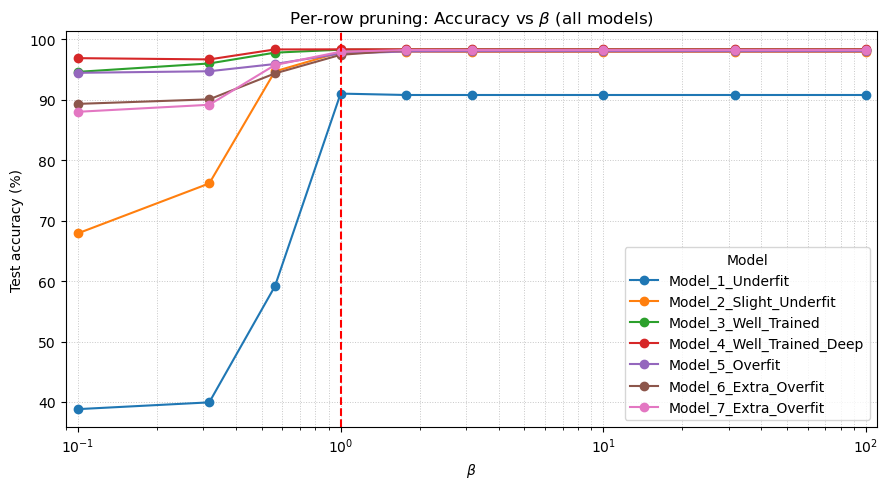

In [8]:
# ============================================================
# Per-row pruning sweep (β) and one figure for all models
# Accuracy vs β (log-x) + red dashed vertical line at β = 1.0
# Saves to: models/plots/accuracy_vs_beta_perrow_all_models.png
# ============================================================

from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt

# Where your models live (as written by your training script)
ROOT_DIR = Path("models")
PLOTS_DIR = ROOT_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# ---- 9 β values on a log scale in [10^-1, 10^2] with β = 1.0 included ----
# exponents chosen so that 0 (i.e., β=1) is included
_beta_exponents = [-1.0, -0.5, -0.25, 0.0, 0.25, 0.5, 1.0, 1.5, 2.0]
BETAS = np.array([10.0**e for e in _beta_exponents], dtype=float)

# Safety check: make sure 1.0 is in the list (within float tolerance)
assert np.any(np.isclose(BETAS, 1.0)), "β=1.0 must be included in the sweep."

def _load_base_model(model_name: str, config: dict):
    """Instantiate the model architecture and load its base (unpruned) weights."""
    base_path = ROOT_DIR / model_name / "base.pth"
    if not base_path.exists():
        raise FileNotFoundError(f"Missing base weights: {base_path.as_posix()}")

    model = LinearModel(
        input_size=28*28,
        output_size=10,
        hidden_size=config["hidden_size"],
        dropout_rate=config["dropout"]
    ).to(device)
    # Load on the right device
    state = torch.load(base_path, map_location=device)
    model.load_state_dict(state)
    model.eval()
    return model

def sweep_perrow_accuracy():
    """
    For each model in model_configs:
      - Reload base weights
      - For each β in BETAS, prune per-row and evaluate test accuracy
    Returns:
      results: dict { model_name: (betas_array, accuracies_list) }
    """
    results = {}
    with torch.no_grad():
        for model_name, config in model_configs.items():
            accuracies = []
            # Reload a clean base for this model (once); the pruner returns a copy.
            base_model = _load_base_model(model_name, config)

            for beta in BETAS:
                # Per-row only, as requested
                pruned = model_per_row_rate(base_model, beta=float(beta), renormalize=False)
                pruned.eval()
                test_loss, test_acc = test(pruned, device, test_loader)  # expected to return % accuracy
                accuracies.append(float(test_acc))

            results[model_name] = (BETAS.copy(), accuracies)
    return results

def plot_all_models_accuracy_vs_beta(results: dict):
    """
    Plot all models on a single figure:
      - x-axis: β (log scale)
      - y-axis: test accuracy (%)
      - vertical red dashed line at β = 1.0
    """
    fig, ax = plt.subplots(figsize=(9, 5))

    for model_name, (betas, accs) in results.items():
        # Use default color cycle; add markers to differentiate
        ax.plot(betas, accs, marker="o", label=model_name)

    # Log-scale on x
    ax.set_xscale("log")
    ax.set_xlabel(r"$\beta$")
    ax.set_ylabel("Test accuracy (%)")
    ax.set_title("Per-row pruning: Accuracy vs $\\beta$ (all models)")

    # Red dashed line at β = 1.0
    ax.axvline(1.0, linestyle="--", linewidth=1.5, color="red")

    # Nice bounds/grid/legend
    xmin = BETAS.min() * 0.9
    xmax = BETAS.max() * 1.1
    ax.set_xlim(xmin, xmax)
    ax.grid(True, which="both", axis="both", linestyle=":", linewidth=0.7, alpha=0.7)
    ax.legend(title="Model")

    fig.tight_layout()
    out_path = PLOTS_DIR / "accuracy_vs_beta_perrow_all_models.png"
    fig.savefig(out_path, dpi=160)
    print(f"Saved plot to: {out_path.as_posix()}")
    plt.show()

if __name__ == "__main__":
    results = sweep_perrow_accuracy()
    plot_all_models_accuracy_vs_beta(results)
